In [ ]:
import pathlib

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch.fft
import torch.utils.data
import torchvision.transforms as T
import tqdm
from torchsummary import summary

from src.data import transforms
from src.data.dataset import BGREMDataset
from src.model.modules import NoOp
from src.model.unet import HalfUNetDiscriminator, UNet

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
noop_model = NoOp()

c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\njytwf\AppData\Local\anaconda3\envs\masters\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
img_paths = list(pathlib.Path("data/processed/dsec/").glob("**/interlaken_00_c*.npy"))
ref_img_paths = list(pathlib.Path("data/ref/").glob("*.npy"))
uzh_img_paths = list(pathlib.Path("data/processed/uzh/").glob("**/highway1*.npy"))
len(img_paths), len(ref_img_paths), len(uzh_img_paths)

(179, 16, 1035)

In [ ]:
np.random.seed(0)
dat = BGREMDataset(
    uzh_img_paths[:16],
    # masker=transforms.DiffIntensityMasker(110),
    masker=transforms.RandomizedMasker(fix_by_idx=True),
    bgr_transform=T.Compose(
        [
            T.ToPILImage(),
            T.ToTensor(),
        ]
    ),
    event_transform=T.Compose(
        [
            transforms.RandomizedSunAdder(0.25),
            transforms.RandomizedBrightnessScaler(0.5, 1.5),
            transforms.RandomizedContrastScaler(0.5, 1.5),
        ]
    ),
    masked_bgr_transform=T.Compose(
        [transforms.RandomizedMaskedAwareGrayscaleAdder(prob=1)]
    ),
    separate_event_channel=False,
    blur_factor=10,
    yuv_interpolation=True,
)

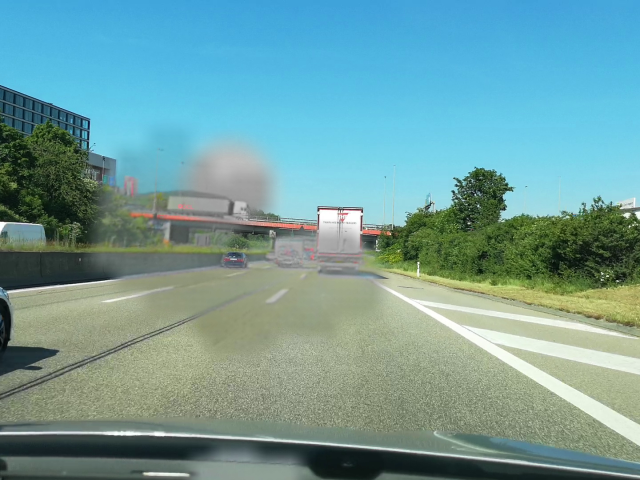

In [ ]:
np.random.seed(0)
x, _ = dat[1]
x = (x.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
showarray(x[:, :, :3])

In [ ]:
dl = torch.utils.data.DataLoader(dat, batch_size=8, shuffle=False)
batched_dat = list(dl)

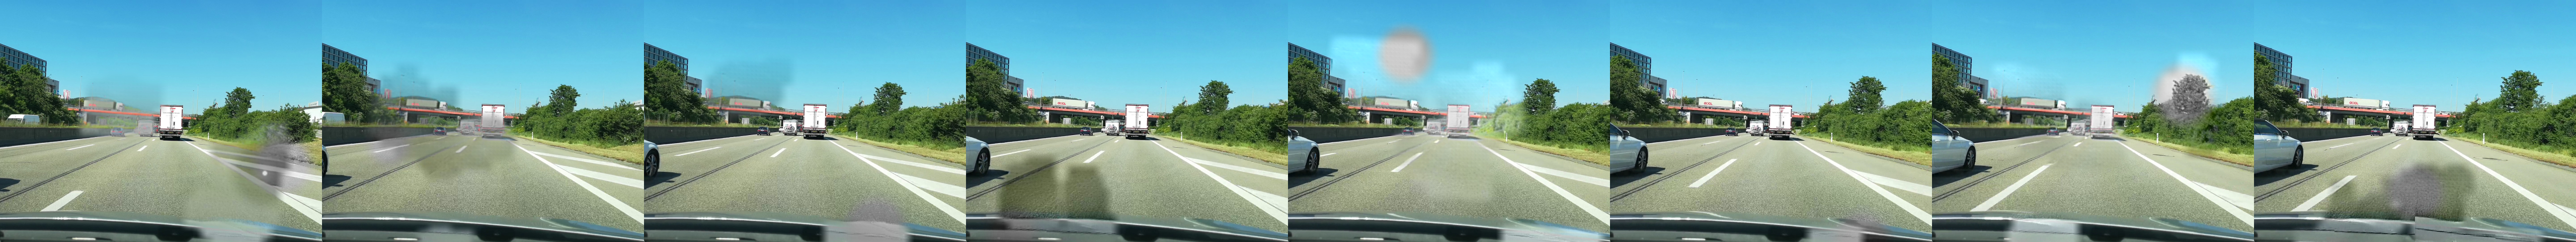

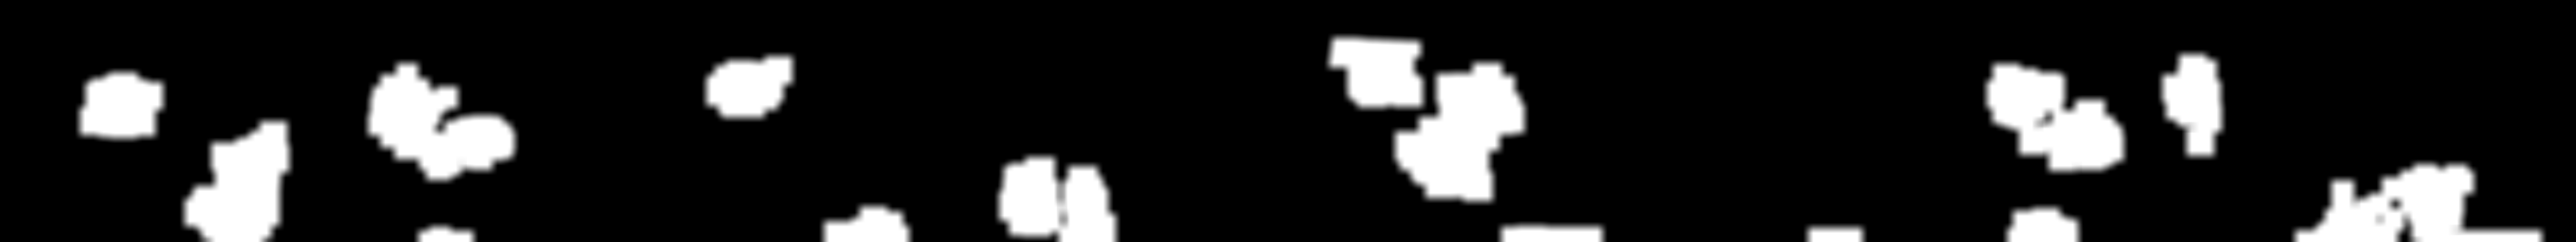

In [27]:
x, _ = batched_dat[0]
x = (x.numpy().transpose(0, 2, 3, 1) * 255.0).astype(np.uint8)

x = np.concatenate(x, axis=1)
showarray(x[:, :, :3])
showarray(x[:, :, 3])
# showarray(x[:, :, 3][:, ::-1])

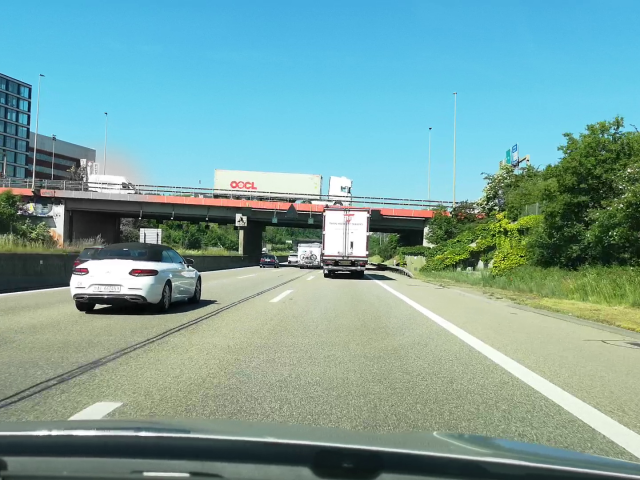

In [ ]:
# get random coords within mask
uzh_samp = np.load(uzh_img_paths[23])
uzh_samp_bgr = uzh_samp[:, :, :3]
uzh_samp_gs = cv2.cvtColor(uzh_samp_bgr, cv2.COLOR_BGR2GRAY)
uzh_samp_gs = np.repeat(uzh_samp_gs[:, :, None], 3, axis=2)

comb_mask = np.zeros_like(uzh_samp_gs, dtype=np.float32)
R = 50
comb_mask = cv2.circle(comb_mask, (100, 200), R, (1, 1, 1), -1)
comb_mask = cv2.GaussianBlur(comb_mask, (31, 31), 15)

combined = uzh_samp_gs * comb_mask + uzh_samp_bgr * (1 - comb_mask)
showarray(combined)